In [1]:
import torch
import os
import tqdm

import sys
sys.path.append("../../..")
from utils.checkpoint import save_ckpt_template as save_ckpt, load_ckpt_template as load_ckpt

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True   # 加速卷积计算
else:
    device = torch.device('cpu')

print(device)

cuda


In [ ]:
from data.septimbre.data import Instruments
dataset = Instruments(
    folder = '../../../data/septimbre/multi_large_256',
    mix = 1,
    input = '.wav',
    output = '.npy'
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=18, shuffle=True, pin_memory=True, num_workers=4)
print("训练集大小: ", len(dataset))
input, label = dataset[0]
print("输入大小: ", input.shape)
print("输出大小: ", label.shape)

val = Instruments(
    folder = '../../../data/septimbre/multi_medium_256',
    mix = 1,
    input = '.wav',
    output = '.npy'
)
valloader = torch.utils.data.DataLoader(val, batch_size=18, shuffle=False, pin_memory=True, num_workers=4)
print("测试集大小: ", len(val))
input, label = val[0]
print("输入大小: ", input.shape)
print("输出大小: ", label.shape)

# CQT配置
from model.config import CONFIG
s_per_frame = CONFIG.s_per_frame

_model = None

训练集大小:  8316
输入大小:  torch.Size([1, 1, 230400])
输出大小:  torch.Size([1, 84, 900])
测试集大小:  720
输入大小:  torch.Size([1, 1, 230400])
输出大小:  torch.Size([1, 84, 900])


In [3]:
# 从分体开始
from basicamt_bn import BasicAMT_BN, BasicAMT_all_BN
_model = BasicAMT_BN().to(device)
optimizer = torch.optim.AdamW(_model.parameters(), lr=2e-4)
checkpoint_path = "basicamt_bn.pth"

# 加载最佳模型
states = load_ckpt(_model, optimizer, "best_" + checkpoint_path)
if not states:
    print("No best checkpoint loaded.")

Checkpoint loaded from 'best_basicamt_bn.pth'
epoch: 11, loss: 6063.112034301757, min_loss: 6358.253883178711


In [ ]:
from basicamt_bn import BasicAMT_BN, BasicAMT_all_BN
if _model is not None:
    model = BasicAMT_all_BN(CONFIG.CQT, _model.state_dict(), CQTlearnable=False).to(device)
    print("model initialized from BasicAMT")
else:
    model = BasicAMT_all_BN(CONFIG.CQT, CQTlearnable=False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, threshold=1e-3)
checkpoint_path = "basicamt_all_bn.pth"
loss_path = "basicamt_all_bn.loss.txt"
min_loss = float('inf')
epoch_now = 0

model initialized from BasicAMT


In [5]:
# 加载上一轮模型参数
states = load_ckpt(model, optimizer, checkpoint_path)
if states:
    min_loss, avg_loss, epoch_now = states
else:
    print("No checkpoint loaded. Training from scratch.")

Checkpoint file 'basicamt_all_bn.pth' does not exist.
No checkpoint loaded. Training from scratch.


In [6]:
model = torch.compile(model)

In [7]:
epoch_total = 50
stage_save_interval = 40    # save checkpoint every $stage_save_interval$ epochs

optimizer.zero_grad()
for epoch in range(epoch_now+1, epoch_total):
    # training
    model.train()
    train_loss = 0
    virtual_batch = 0
    for (input, target) in tqdm.tqdm(dataloader):
        input = input.to(device)    # input: (batch, mix, 2, time)
        target = target.to(device)  # target: (batch, mix, 7 * 12, 660)

        # 由于basicamt的目标没有分离音色，因此mix仅仅是数据增强的手段
        if dataset.mix > 1:
            mixed = torch.mean(input, dim=1, keepdim=False)  # 混合后的CQT
            midi_mixed, _ = target.max(dim=-3, keepdim=False)
        else:
            mixed = input.squeeze(dim=1)
            midi_mixed = target.squeeze(dim=1)

        mixed = mixed + torch.randn_like(mixed) * 0.005   # 加入噪声 经过听觉和可视化觉得0.005是一个合适的值
        # midi_mixed: (batch, 7 * 12, 660)

        onset, note = model(mixed)
        # onset & note: (batch, 7 * 12, 660)
        loss = BasicAMT_BN.loss(onset, note, midi_mixed)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= len(dataloader)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (input, target) in tqdm.tqdm(valloader):
            input = input.to(device)
            target = target.to(device)

            if val.mix > 1:
                mixed = torch.sum(input, dim=1, keepdim=False)
                midi_mixed, _ = target.max(dim=-3, keepdim=False)
            else:
                mixed = input.squeeze(dim=1)
                midi_mixed = target.squeeze(dim=1)

            onset, note = model(mixed)
            loss = BasicAMT_BN.loss(onset, note, midi_mixed)
            val_loss += loss.item()

        val_loss /= len(valloader)
    
    final_loss = val_loss * 0.85 + train_loss * 0.15
    schedular.step(final_loss)

    # save checkpoint
    checkpoint_filename = f"epoch{epoch}.pth" if epoch % stage_save_interval == 0 else checkpoint_path
    save_ckpt(epoch, model, min_loss, final_loss, optimizer, checkpoint_filename)
    if final_loss < min_loss:
        min_loss = final_loss

    print(f"====> Epoch: {epoch} Average train loss: {train_loss:.4f}; Average val loss: {val_loss:.4f}")
    with open(loss_path, 'a') as f:
        f.write(f"{epoch}:\ttrain_loss: {train_loss:.4f}\tval_loss: {val_loss:.4f}\n")
    epoch_now = epoch

100%|██████████| 40/40 [00:04<00:00,  9.28it/s]


====> Epoch: 1 Average train loss: 6289.1968; Average val loss: 6147.0098


100%|██████████| 40/40 [00:01<00:00, 33.80it/s]


====> Epoch: 2 Average train loss: 5664.3571; Average val loss: 5855.9005


100%|██████████| 40/40 [00:01<00:00, 33.86it/s]


====> Epoch: 3 Average train loss: 5418.8954; Average val loss: 5772.9607


100%|██████████| 40/40 [00:01<00:00, 31.57it/s]


====> Epoch: 4 Average train loss: 5249.6831; Average val loss: 5708.2888


100%|██████████| 40/40 [00:01<00:00, 29.72it/s]


====> Epoch: 5 Average train loss: 5121.7548; Average val loss: 5561.0218


100%|██████████| 40/40 [00:01<00:00, 29.90it/s]


====> Epoch: 6 Average train loss: 5033.8900; Average val loss: 5545.1052


100%|██████████| 40/40 [00:01<00:00, 31.37it/s]


====> Epoch: 7 Average train loss: 4949.7597; Average val loss: 5509.9416


100%|██████████| 40/40 [00:01<00:00, 30.06it/s]


====> Epoch: 8 Average train loss: 4881.9915; Average val loss: 5351.8560


100%|██████████| 40/40 [00:01<00:00, 28.62it/s]


====> Epoch: 9 Average train loss: 4822.6416; Average val loss: 5384.8674


100%|██████████| 40/40 [00:01<00:00, 28.81it/s]


====> Epoch: 10 Average train loss: 4771.7957; Average val loss: 5237.4748


100%|██████████| 40/40 [00:01<00:00, 28.68it/s]


====> Epoch: 11 Average train loss: 4732.5855; Average val loss: 5341.5892


100%|██████████| 40/40 [00:01<00:00, 33.27it/s]


====> Epoch: 12 Average train loss: 4701.6225; Average val loss: 5205.8574


100%|██████████| 40/40 [00:01<00:00, 30.74it/s]


====> Epoch: 13 Average train loss: 4659.8376; Average val loss: 5228.9972


100%|██████████| 40/40 [00:01<00:00, 31.23it/s]


====> Epoch: 14 Average train loss: 4635.5667; Average val loss: 5202.6246


100%|██████████| 40/40 [00:01<00:00, 32.94it/s]


====> Epoch: 15 Average train loss: 4601.9699; Average val loss: 5087.0354


100%|██████████| 40/40 [00:01<00:00, 33.02it/s]


====> Epoch: 16 Average train loss: 4578.8747; Average val loss: 5084.3164


100%|██████████| 40/40 [00:01<00:00, 30.89it/s]


====> Epoch: 17 Average train loss: 4555.9814; Average val loss: 5044.9006


100%|██████████| 40/40 [00:01<00:00, 32.68it/s]


====> Epoch: 18 Average train loss: 4532.8351; Average val loss: 5035.9209


100%|██████████| 40/40 [00:01<00:00, 32.78it/s]


====> Epoch: 19 Average train loss: 4509.0073; Average val loss: 5065.0444


100%|██████████| 40/40 [00:01<00:00, 29.02it/s]


====> Epoch: 20 Average train loss: 4488.3239; Average val loss: 4936.5346


100%|██████████| 40/40 [00:01<00:00, 34.49it/s]


====> Epoch: 21 Average train loss: 4470.5953; Average val loss: 4970.3773


100%|██████████| 40/40 [00:01<00:00, 33.91it/s]


====> Epoch: 22 Average train loss: 4457.8125; Average val loss: 5036.2268


100%|██████████| 40/40 [00:01<00:00, 32.83it/s]


====> Epoch: 23 Average train loss: 4442.7712; Average val loss: 4891.4961


100%|██████████| 40/40 [00:01<00:00, 33.16it/s]


====> Epoch: 24 Average train loss: 4421.0215; Average val loss: 4943.2891


100%|██████████| 40/40 [00:01<00:00, 33.04it/s]


====> Epoch: 25 Average train loss: 4410.5578; Average val loss: 5021.8490


100%|██████████| 40/40 [00:01<00:00, 34.14it/s]


====> Epoch: 26 Average train loss: 4402.1351; Average val loss: 4891.2551


100%|██████████| 40/40 [00:01<00:00, 32.32it/s]


====> Epoch: 27 Average train loss: 4382.1205; Average val loss: 5016.7225


100%|██████████| 40/40 [00:01<00:00, 32.96it/s]


====> Epoch: 28 Average train loss: 4376.8700; Average val loss: 4929.7281


100%|██████████| 40/40 [00:01<00:00, 33.73it/s]


====> Epoch: 29 Average train loss: 4360.5128; Average val loss: 4903.6494


100%|██████████| 40/40 [00:01<00:00, 32.57it/s]


====> Epoch: 30 Average train loss: 4307.1067; Average val loss: 4837.2981


100%|██████████| 40/40 [00:01<00:00, 31.45it/s]


====> Epoch: 31 Average train loss: 4295.9221; Average val loss: 4889.3061


100%|██████████| 40/40 [00:01<00:00, 32.48it/s]


====> Epoch: 32 Average train loss: 4299.6126; Average val loss: 4914.3321


100%|██████████| 40/40 [00:01<00:00, 31.89it/s]


====> Epoch: 33 Average train loss: 4291.0001; Average val loss: 4878.4271


100%|██████████| 40/40 [00:01<00:00, 33.21it/s]


====> Epoch: 34 Average train loss: 4273.7761; Average val loss: 4864.1420


100%|██████████| 40/40 [00:01<00:00, 31.93it/s]


====> Epoch: 35 Average train loss: 4270.8038; Average val loss: 4888.1105


100%|██████████| 40/40 [00:01<00:00, 32.24it/s]


====> Epoch: 36 Average train loss: 4270.1320; Average val loss: 4856.3480


100%|██████████| 40/40 [00:01<00:00, 34.18it/s]


====> Epoch: 37 Average train loss: 4262.2460; Average val loss: 4852.8091


100%|██████████| 40/40 [00:01<00:00, 33.05it/s]


====> Epoch: 38 Average train loss: 4263.4879; Average val loss: 4863.3273


100%|██████████| 40/40 [00:01<00:00, 33.95it/s]


====> Epoch: 39 Average train loss: 4261.1456; Average val loss: 4853.8219


100%|██████████| 40/40 [00:01<00:00, 33.88it/s]


====> Epoch: 40 Average train loss: 4259.2213; Average val loss: 4867.9326


100%|██████████| 40/40 [00:01<00:00, 33.52it/s]


====> Epoch: 41 Average train loss: 4261.3757; Average val loss: 4859.1610


100%|██████████| 40/40 [00:01<00:00, 34.28it/s]


====> Epoch: 42 Average train loss: 4259.7301; Average val loss: 4860.0594


100%|██████████| 40/40 [00:01<00:00, 33.31it/s]


====> Epoch: 43 Average train loss: 4259.1770; Average val loss: 4854.6314


100%|██████████| 40/40 [00:01<00:00, 33.02it/s]


====> Epoch: 44 Average train loss: 4258.4725; Average val loss: 4857.9270


100%|██████████| 40/40 [00:01<00:00, 33.46it/s]


====> Epoch: 45 Average train loss: 4259.6332; Average val loss: 4858.6307


100%|██████████| 40/40 [00:01<00:00, 34.96it/s]


====> Epoch: 46 Average train loss: 4257.3299; Average val loss: 4847.6501


100%|██████████| 40/40 [00:01<00:00, 35.26it/s]


====> Epoch: 47 Average train loss: 4256.2849; Average val loss: 4862.3872


100%|██████████| 40/40 [00:01<00:00, 34.84it/s]


====> Epoch: 48 Average train loss: 4259.4074; Average val loss: 4859.6509


100%|██████████| 40/40 [00:01<00:00, 35.06it/s]

====> Epoch: 49 Average train loss: 4258.6124; Average val loss: 4853.1364


In [8]:
model.cqt.cqt_kernels.requires_grad

False

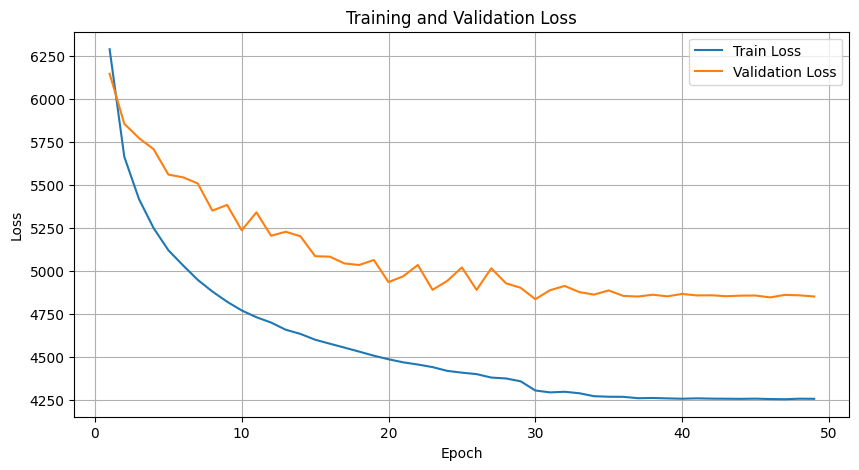

In [9]:
# 绘制训练和验证损失曲线
import matplotlib.pyplot as plt

epochs = []
train_losses = []
val_losses = []

with open(loss_path, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        epoch = int(parts[0].split(':')[0])
        train_loss = float(parts[1].split(': ')[1])
        val_loss = float(parts[2].split(': ')[1])
        
        epochs.append(epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 测试模型

In [10]:
# 加载最佳模型
states = load_ckpt(model, optimizer, "best_" + checkpoint_path)
if states:
    min_loss, avg_loss, epoch_now = states
else:
    print("No best checkpoint loaded.")

Checkpoint loaded from 'best_basicamt_all_bn.pth'
epoch: 30, loss: 4757.769384809222, min_loss: 4817.887144575242


In [11]:
# 切换到cpu 因为benchmark会导致初次运行时间长
device = torch.device('cpu')
model = model.to(device)
torch.backends.cudnn.benchmark = False

Sample rate: 22050
Channels: 2
Sample width: 2
Number of frames: 2902528
Duration (s): 131.63392290249433
data num: 5805056
torch.Size([1, 2, 2902528])


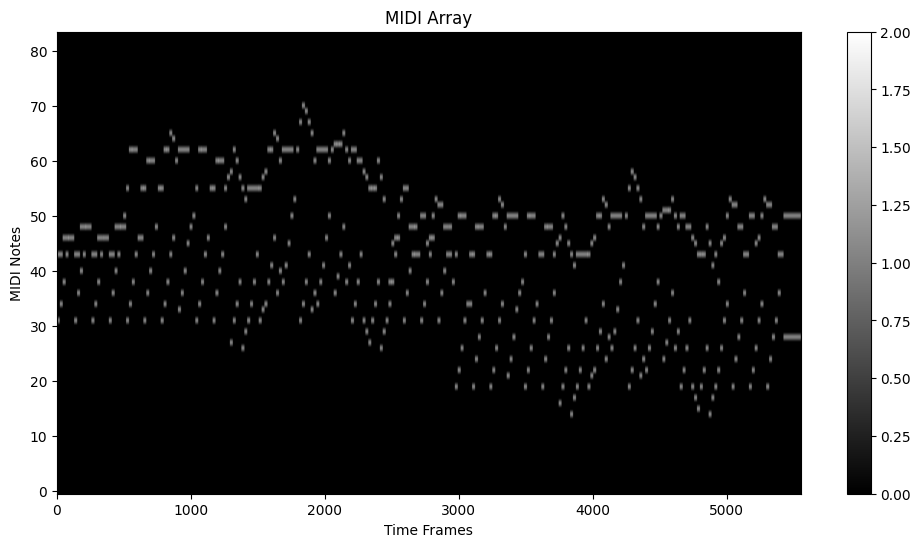

(84, 5556)


In [12]:
# 读取音频
import torchaudio
from utils.midiarray import midi2numpy
from utils.wavtool import waveInfo
import matplotlib.pyplot as plt
import numpy as np

# test_wave_path = "../../../data/inferMusic/piano_short.wav"
test_wave_path = "../../../data/inferMusic/孤独な巡礼simple.wav"
waveInfo(test_wave_path)

waveform, sample_rate = torchaudio.load(test_wave_path, normalize=True)
waveform = waveform.unsqueeze(0)
print(waveform.shape)

test_midi_path = test_wave_path.replace('.wav', '.mid')
s_per_frame = 256 / 22050
midi_array = midi2numpy(test_midi_path, s_per_frame)
plt.figure(figsize=(12, 6))
plt.imshow(midi_array, aspect='auto', origin='lower', cmap='gray')
plt.colorbar()
plt.title('MIDI Array')
plt.xlabel('Time Frames')
plt.ylabel('MIDI Notes')
plt.show()
print(midi_array.shape)

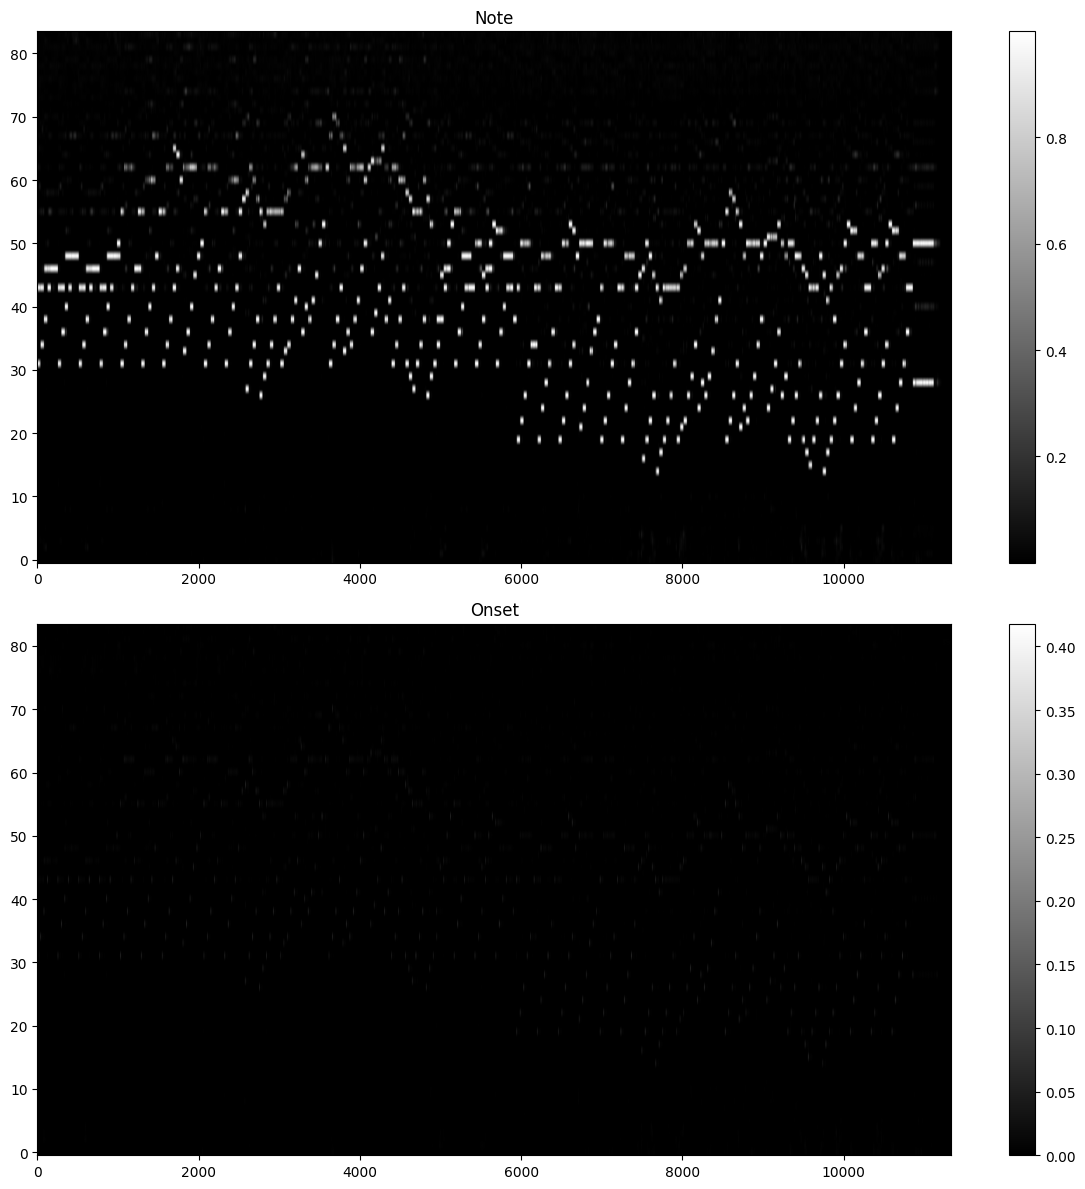

In [13]:
model.eval()
with torch.no_grad():
    onset, note = model(waveform)
    onset = onset.cpu().numpy()[0]
    note = note.cpu().numpy()[0]
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 1, 1)
    plt.title('Note')
    plt.imshow(note, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

    plt.subplot(2, 1, 2)
    plt.title('Onset')
    plt.imshow(onset, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

In [14]:
# final model to be used by others
torch.save(model, "basicamt_model_bn.pth")